# Figure 6: Terminal exon site analysis

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%run -i notebook_setup.py

Using TensorFlow backend.


## IMPORTS AND SETUP

In [4]:
import utilities
from utilities import genomic_context

import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.proportion import test_proportions_2indep


## IMPORT DATA

In [5]:
PROJECT = "/projects/b1080/eks/polyadenylation"
DATADIR = os.path.join(PROJECT, "manuscripts", "01_development", "data")
RESDIR  = os.path.join(PROJECT, "manuscripts", "01_development", "analysis", "resources")
OUTDIR  = os.path.join(PROJECT, "manuscripts", "01_development", "figures", "Figure_06")
os.makedirs(OUTDIR, exist_ok = True)


## Data loading and preparation

In [6]:
data = (pd.read_csv(os.path.join(RESDIR, 'xte_rawdata.txt'), sep = "\t")
        .rename(columns = {
            'feature_gene'       : 'gene', 
            'cluster_reads_slop' : 'reads',
        }))

print(data.shape)


(250992, 25)


#### Define features

In [7]:
te_feature_dict = {
    'predicted_strength'       : 'PolyaStrength of proximal site',
    'match_strength'           : 'PolyaStrength of paired distal site',
    'relstrength'              : 'Difference in PolyaStrength (distal-proximal)',
    'reldist'                  : 'Distance between sites (log10)',
    'up_intron_log10'          : 'Upstream intron size (log10)',
    'distance_antisense_log10' : 'Downstream antisense gene distance (log10)',
}

te_features = list(te_feature_dict.keys())
te_labels = [te_feature_dict.get(_) for _ in te_features]

te_names_minimal = ['strength', 'relstrength', 'reldist', 'up_intron_log10', 'distance_first_upstream3ss', 'distance_antisense_log10']


#### Transform features

In [8]:
data['up_intron_log10'] = np.log10(data['up_intron'] + 1)

data['distance_sense_log10']     = np.log10(data['distance_downstream_gene_sense'] + 1)
data['distance_antisense_log10'] = np.log10(data['distance_downstream_gene_antisense'] + 1)
data['distance_down_log10']      = data[['distance_sense_log10','distance_antisense_log10']].min(axis=1)

data.loc[data['distance_antisense_log10'] >= data['distance_sense_log10'], 'down_gene_type'] = 'sense'
data.loc[data['distance_antisense_log10']  < data['distance_sense_log10'], 'down_gene_type'] = 'antisense'


#### Subset sites meeting minimal 3'READS support requirements

In [9]:
condREADS = (data['reads'] >= 10)
condSENSE = ~((data['down_gene_type'] == 'sense') & (data['distance_sense_log10'] == 0))
condCOMB  = (condREADS & condSENSE)
print(condREADS.sum(), condSENSE.sum(), condCOMB.sum())

filt_data = data.loc[condCOMB].copy()
print(filt_data.shape)

strongest_data = filt_data.groupby('gene', as_index = False).apply(lambda df: df.sort_values('reads').tail(1))
print(strongest_data.shape)


55775 249251 55018
(55018, 30)
(16574, 30)


In [10]:
print(data['gene'].nunique())
print(filt_data['gene'].nunique())
print(strongest_data['gene'].nunique())


20701
16574
16574


#### Generate pairs of sites with sufficient expression differences

In [11]:
try:
    
    strongest_ann  = pd.read_csv(os.path.join(RESDIR, 'xte_data.strongest_vs_random.ann.txt'), sep = "\t")
    strongest_comb = pd.read_csv(os.path.join(RESDIR, 'xte_data.strongest_vs_random.comb.txt'), sep = "\t")
    
except FileNotFoundError:

    strongest_ann = strongest_data.apply(lambda row : genomic_context.find_comparison(row, data = filt_data, comptype = 'random', random_state = 1234), axis = 1)
    strongest_nona = strongest_ann[~strongest_ann[te_names_minimal].isnull().any(axis = 1)].copy()
    strongest_comb = genomic_context.create_comparison(strongest_nona, data, reftype = 'strongest', alttype = 'random')

    strongest_ann.to_csv(os.path.join(RESDIR, 'xte_data.strongest_vs_random.ann.txt'), sep = "\t", index = False)
    strongest_comb.to_csv(os.path.join(RESDIR, 'xte_data.strongest_vs_random.comb.txt'), sep = "\t", index = False)

print(strongest_ann.shape)
print(strongest_comb.shape)


(16574, 38)
(18886, 37)


In [12]:
strongest_comb['predicted_strength'] = strongest_comb['strength'].copy()
strongest_comb['match_strength'] = strongest_comb['relstrength'] + strongest_comb['predicted_strength']

print("\nStrongest all:\t", strongest_comb.shape)
print("\nDownstream gene orientation:\n", strongest_comb.down_gene_type.value_counts())



Strongest all:	 (18886, 39)

Downstream gene orientation:
 antisense    10786
sense         8090
Name: down_gene_type, dtype: int64


#### Partition data into training and testing splits

In [13]:
train_size = int(0.9 * len(strongest_comb))
test_size = int(len(strongest_comb) - train_size)
    
np.random.seed(1234)
rand = np.random.rand(len(strongest_comb))

train_part = np.argpartition(rand, train_size)    
train_idx  = train_part[:train_size]
test_idx   = train_part[train_size:]

strongest_comb.loc[train_idx, 'split'] = 'train'
strongest_comb.loc[test_idx,  'split'] = 'test'

print(strongest_comb.split.value_counts())


train    16997
test      1889
Name: split, dtype: int64


In [14]:
prox_filt, prox_all, prox_tr, prox_te, prox_scaler = genomic_context.prep_data(strongest_comb, strongest_comb, te_names_minimal, 'relscore', 'score_logit', categorical = [], subset = ('comppos', 'proximal'))

(pXall_m, pXall_s, pYall_c, pYall_r) = prox_all
(pXtr_o_all, pXtr_s_all, pYtr_c_all, pYtr_r_all, pXtr_o_filt, pXtr_s_filt, pYtr_c_filt, pYtr_r_filt) = prox_tr
(pXte_o_all, pXte_s_all, pYte_c_all, pYte_r_all, pXte_o_filt, pXte_s_filt, pYte_c_filt, pYte_r_filt) = prox_te

pAll_c = pXall_m
pAll_c['outcome'] = pYall_c

pTr_c_filt = pXtr_s_filt
pTr_c_filt['outcome'] = pYtr_c_filt

pTe_c_filt = pXte_s_filt
pTe_c_filt['outcome'] = pYte_c_filt


After filtering for: ('comppos', 'proximal')
	All data =  (9443, 40)
	Filt data =  (9443, 40)
	Train/test splits =  train    8532
test      911
Name: split, dtype: int64
CAT: []
NONCAT: ['strength', 'relstrength', 'reldist', 'up_intron_log10', 'distance_first_upstream3ss', 'distance_antisense_log10']


### Comparison Models

#### Fit logistic regression model

In [15]:
ffo_pmod = smf.logit(formula = "outcome ~ relstrength + reldist + up_intron_log10 + distance_antisense_log10", 
                        data = pTr_c_filt).fit(disp = 0)
print(ffo_pmod.summary())

ffo_all_pred_c     = ffo_pmod.predict(pAll_c)
ffo_filt_tr_pred_c = ffo_pmod.predict(pTr_c_filt)
ffo_filt_te_pred_c = ffo_pmod.predict(pTe_c_filt)

ffo_tr_auroc, ffo_tr_auprc = genomic_context.calculate_auc(pYtr_c_filt, ffo_filt_tr_pred_c)
ffo_te_auroc, ffo_te_auprc = genomic_context.calculate_auc(pYte_c_filt, ffo_filt_te_pred_c)
print("FFO AUROC: Train = ", ffo_tr_auroc, ", Test = ", ffo_te_auroc)
print("FFO AUPRC: Train = ", ffo_tr_auprc, ", Test = ", ffo_te_auprc)

with open(os.path.join(OUTDIR, 'proximal_comparison.model.pickle'), mode = 'wb') as handle:
    pickle.dump(ffo_pmod, handle)
    
with open(os.path.join(OUTDIR, 'proximal_comparison.scaler.pickle'), mode = 'wb') as handle:
    pickle.dump(prox_scaler, handle)
    
with open(os.path.join(OUTDIR, 'proximal_comparison.training.pickle'), mode = 'wb') as handle:
    pickle.dump(prox_tr, handle)
    
with open(os.path.join(OUTDIR, 'proximal_comparison.testing.pickle'), mode = 'wb') as handle:
    pickle.dump(prox_te, handle)


                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:                 8532
Model:                          Logit   Df Residuals:                     8527
Method:                           MLE   Df Model:                            4
Date:                Fri, 27 Oct 2023   Pseudo R-squ.:                  0.5260
Time:                        12:49:36   Log-Likelihood:                -2785.8
converged:                       True   LL-Null:                       -5877.3
Covariance Type:            nonrobust   LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.4464      0.035     12.821      0.000       0.378       0.515
relstrength                 -3.1070      0.068    -45.879      0.000      -3.240      -2.

#### Combining original data with model predictions

In [16]:
strongest_pred = strongest_comb.copy()

strongest_pred.loc[ffo_filt_tr_pred_c.index, 'pred_prob'] = ffo_filt_tr_pred_c
strongest_pred.loc[ffo_filt_te_pred_c.index, 'pred_prob'] = ffo_filt_te_pred_c

strongest_pred['pred_class']     = (strongest_pred['pred_prob'] >= 0.5).astype(int)
strongest_pred['pred_prob_clip'] = np.clip(strongest_pred['pred_prob'], 1e-6, 1 - 1e-6)
strongest_pred['pred_prob_or']   = np.log2(strongest_pred['pred_prob_clip'] / (1 - strongest_pred['pred_prob_clip']))

strongest_pred.loc[(strongest_pred['relscore'] == 1) & (strongest_pred['pred_class'] == 1), 'pred_type'] = 'true_positive'
strongest_pred.loc[(strongest_pred['relscore'] == 1) & (strongest_pred['pred_class'] == 0), 'pred_type'] = 'false_negative'
strongest_pred.loc[(strongest_pred['relscore'] == 0) & (strongest_pred['pred_class'] == 1), 'pred_type'] = 'false_positive'
strongest_pred.loc[(strongest_pred['relscore'] == 0) & (strongest_pred['pred_class'] == 0), 'pred_type'] = 'true_negative'

print(strongest_pred.pred_type.value_counts() / len(strongest_pred))


true_negative     0.464153
false_negative    0.259928
true_positive     0.240072
false_positive    0.035847
Name: pred_type, dtype: float64


In [17]:
matched_sites_dict = {}

for i, row in strongest_pred.iterrows():
    
    if (row['gene'] not in matched_sites_dict):
        matched_sites_dict[row['gene']] = {}
    
    matched_sites_dict[row['gene']][row['comppos']] = {
        'comptype' : row['comptype'], 
        'pred_prob' : row['pred_prob'],
    }

strongest_pred['pred_prob_norm']      = strongest_pred.apply(lambda row : row['pred_prob'] / (matched_sites_dict[row['gene']]['proximal']['pred_prob'] + matched_sites_dict[row['gene']]['distal']['pred_prob']), axis = 1)
strongest_pred['pred_prob_norm_clip'] = np.clip(strongest_pred['pred_prob_norm'], 1e-6, 1 - 1e-6)
strongest_pred['pred_prob_norm_or']   = np.log2(strongest_pred['pred_prob_norm_clip'] / (1 - strongest_pred['pred_prob_norm_clip']))


#### Classification performance

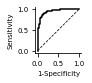

Corresponding metrics:
	Test AUROC = 0.9371013310808843


In [18]:
fig,ax = plt.subplots(1, 1, figsize = (1.25,1.25))

prox_auc = genomic_context.plot_roc(ax, 
                                    strongest_pred.loc[(strongest_pred['comppos'] == 'proximal') & (strongest_pred['split'] == 'test'), 'relscore'], 
                                    strongest_pred.loc[(strongest_pred['comppos'] == 'proximal') & (strongest_pred['split'] == 'test'), 'pred_prob'],
                                    'Test')


ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_major_locator(MultipleLocator(0.5))

ax.get_legend().remove()

plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, 'classification_roc.proximal_test.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


print("Corresponding metrics:")
print(f"\tTest AUROC = {prox_auc}")


#### Usage validation using ENCODE RNA-seq data

In [19]:
ENCODE_DIR = os.path.join(PROJECT, "model", "rna_validation", "encode_project")

strongest_prox = strongest_pred.loc[strongest_pred['comppos'] == 'proximal'].copy()
print(strongest_prox.shape)


(9443, 48)


Original data shape: (9443, 48)
Filtered data shape: (9439, 48)
Output results shape: (9439, 2)


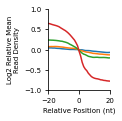

In [20]:
fig, ax = plt.subplots(1,1, figsize = (1.75,1.75))

distance = 20
prox_a172_res = genomic_context.quantify_reads_around(strongest_prox, ENCODE_DIR, 'A172', distance = distance, subset = [('distance_first_upstream3ss', distance)])
genomic_context.make_read_plots(ax, prox_a172_res, 'proximal_terminal_exon', 'A172', distance)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.get_legend().remove()
ax.set_ylim((-1,1))

plt.tight_layout(rect = [0, 0.03, 0.97, 1])
plt.savefig(os.path.join(OUTDIR, 'rna_validation.proximal.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


## Confirmatory boxplots for model predictors

In [21]:
hilo_perc = 50
hilo_cuts = [0, (100-hilo_perc)/100, 1]
hilo_labs = ['Low', 'High']
palette   = ["#a4c9e3", "#245475"]

strongest_prox['cuts'], cut_bins = pd.qcut(strongest_prox['score_logit'], q = hilo_cuts, labels = hilo_labs, retbins = True)
print(strongest_prox['cuts'].value_counts())


Low     4722
High    4721
Name: cuts, dtype: int64


In [22]:
selected_features = ['predicted_strength', 'match_strength', 'relstrength', 'reldist', 'up_intron_log10', 'distance_antisense_log10']
selected_labels   = [te_feature_dict[f] for f in selected_features]


#### PolyaStrength by site usage

PolyaStrength of proximal site:
N_Low	N=4722
N_High	N=4721
Baseline	WRS P-val = 0.000E+00


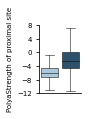

In [23]:
genomic_context.boxplot_features_outcome(OUTDIR, strongest_prox, 'te',
                                         ['predicted_strength'], [te_feature_dict.get("predicted_strength")],
                                         'cuts', ['Low','High'], palette,
                                         figsize = (0.75,1.25), ylims_main=(-12,8), ytickint_main = 4)


#### Paired site strength by site usage

PolyaStrength of paired distal site:
N_Low	N=4722
N_High	N=4721
Baseline	WRS P-val = 0.000E+00


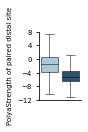

In [24]:
genomic_context.boxplot_features_outcome(OUTDIR, strongest_prox, 'te',
                                         [selected_features[1]], [selected_labels[1]],
                                         'cuts', ['Low','High'], palette,
                                         figsize = (0.75,1.25), ylims_main=(-12,8), ytickint_main = 4)


Difference in PolyaStrength (distal-proximal):
N_Low	N=4722
N_High	N=4721
Baseline	WRS P-val = 0.000E+00


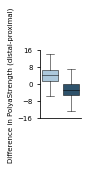

In [25]:
genomic_context.boxplot_features_outcome(OUTDIR, strongest_prox, 'te',
                                         [selected_features[2]], [selected_labels[2]],
                                         'cuts', ['Low','High'], palette,
                                         figsize = (0.75,1.25), ylims_main=(-16,16), ytickint_main = 8)


#### Genomic features after controlling for PolyaStrength and strength difference via quantile sampling

In [26]:
p_sampled = genomic_context.twovar_quantile_sampling(strongest_prox, 
                                                     ['predicted_strength','relstrength'],
                                                     hilo_labs = ['Low','High'],
                                                     random_state = 1427143709)


STARTING QUANTILE SAMPLING
Sampling by predicted_strength, relstrength


/projects/b1080/eks/polyadenylation/manuscripts/01_development/utilities/genomic_context.py:282: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  bin_cut_mins = bin_cut_counts.loc[bin_cut_counts.groupby(sample_var_bins)['count'].idxmin()].copy()


Random state: 1427143709 0.9277877150165663 0.08357534761921857


Distance between sites (log10):
N_Low	N=1186
N_High	N=1186
Baseline	WRS P-val = 2.919E-30


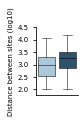

In [27]:
genomic_context.boxplot_features_outcome(OUTDIR, p_sampled, 'te',
                                         [selected_features[3]], [selected_labels[3]],
                                         'cuts', ['Low','High'], palette,
                                         figsize = (0.75,1.25), ylims_main=(1.75,4.5), ytickint_main = 0.5)


Upstream intron size (log10):
N_Low	N=1186
N_High	N=1186
Baseline	WRS P-val = 1.065E-08


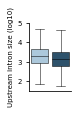

In [28]:
genomic_context.boxplot_features_outcome(OUTDIR, p_sampled, 'te',
                                         [selected_features[4]], [selected_labels[4]],
                                         'cuts', ['Low','High'], palette,
                                         figsize = (0.75,1.25), ylims_main=(1.5,5), ytickint_main = 1)


Downstream antisense gene distance (log10):
N_Low	N=1186
N_High	N=1186
Baseline	WRS P-val = 1.290E-06


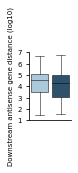

In [29]:
genomic_context.boxplot_features_outcome(OUTDIR, p_sampled, 'te',
                                         [selected_features[5]], [selected_labels[5]],
                                         'cuts', ['Low','High'], palette,
                                         figsize = (0.75,1.25), ylims_main=(1,7), ytickint_main = 1)


#### Visualization of controlled strength and strength difference

predicted_strength WRS P-val = 9.278E-01


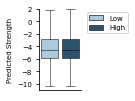

In [30]:
fig,ax = plt.subplots(1,1, figsize = (0.75, 1.5))

sns.boxplot(data = p_sampled, x = 'cuts', y = 'predicted_strength', order = ['Low','High'],
            hue = 'cuts', hue_order = ['Low','High'], palette = palette, dodge = False,
            boxprops = {'edgecolor' : 'black', 'linewidth' : 0.5},
            medianprops = {'color' : 'black', 'linewidth' : 0.5},
            whiskerprops = {'color' : 'black', 'linewidth' : 0.5},
            capprops = {'color' : 'black', 'linewidth' : 0.5},
            flierprops = {'color' : 'black'},
            ax = ax, showfliers = False)

wrs = st.ranksums(p_sampled.loc[p_sampled['cuts'] == 'Low', 'predicted_strength'],
                  p_sampled.loc[p_sampled['cuts'] == 'High', 'predicted_strength'])[1]

print(f"predicted_strength WRS P-val = {wrs:.03E}")

ax.set_ylim(-11,2)
ax.yaxis.set_major_locator(MultipleLocator(2))
ax.set_ylabel('Predicted Strength')

ax.set_xticks([])
ax.set_xlabel("")

ax.legend(bbox_to_anchor = (1.05,1))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, f'{selected_features[5]}_by_usage.comppos_proximal.control.predstr.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


relStrength WRS P-val = 8.358E-02


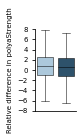

In [31]:
fig,ax = plt.subplots(1,1, figsize = (0.75, 1.5))

sns.boxplot(data = p_sampled, x = 'cuts', y = 'relstrength', order = ['Low','High'],
            hue = 'cuts', hue_order = ['Low','High'], palette = palette, dodge = False,
            boxprops = {'edgecolor' : 'black', 'linewidth' : 0.5},
            medianprops = {'color' : 'black', 'linewidth' : 0.5},
            whiskerprops = {'color' : 'black', 'linewidth' : 0.5},
            capprops = {'color' : 'black', 'linewidth' : 0.5},
            flierprops = {'color' : 'black'},
            ax = ax, showfliers = False)

wrs = st.ranksums(p_sampled.loc[p_sampled['cuts'] == 'Low', 'relstrength'],
                  p_sampled.loc[p_sampled['cuts'] == 'High', 'relstrength'])[1]

print(f"relStrength WRS P-val = {wrs:.03E}")

ax.get_legend().remove()
ax.set_ylim(-8,8)
ax.yaxis.set_major_locator(MultipleLocator(2))
ax.set_ylabel('Relative difference in polyaStrength')

ax.set_xticks([])
ax.set_xlabel("")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, f'{selected_features[5]}_by_usage.comppos_proximal.control.relstrength.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()
